<a href="https://colab.research.google.com/github/abksyed/02MNIST/blob/master/01%20Handwritten%20Number%20Detection%20using%20PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

**Creating Class**

In [0]:
class Net(nn.Module):

  def __init__(self):
    super(Net, self).__init__() # Inheriting __init__ method from  nn.Module Class
    self.conv1 = nn.Conv2d(1, 32, 3, padding= 1) #Creating Conv2d Method, with 1 channels in input image (28 x 28 x 1 - before padding), 
                                                  #and giving 32 channels in the output using 32 kernels of size 3 x 3 x 1 and padding of 1. Receptive Field of 3
    
    self.conv2 = nn.Conv2d(32, 64, 3, padding= 1) #Creating Conv2d Method, with 32 channels in input image (28 x 28 x 32 - before padding), 
                                                  #and giving 64 channels in the output using 64 kernels of size 3 x 3 x 1 and padding of 1. Receptive Field of 5
    
    self.pool1 = nn.MaxPool2d(2,2) #Creating a MaxPool2d Method, with kernel of 2 and stride 2, taking an input of (28 x 28 x 64) giving an output of (14 X 14 X 64). Receptive Field of 10
    
    self.conv3 = nn.Conv2d(64, 128, 3, padding= 1) #Creating Conv2d Method, with 64 channels in input image (14 x 14 x 64 - before padding), 
                                                    #and giving 128 channels in the output using 128 kernels of size 3 x 3 x 1 and padding of 1. Receptive Field of 12
    
    self.conv4 = nn.Conv2d(128, 256, 3, padding= 1) #Creating Conv2d Method, with 128 channels in input image (14 x 14 x 128 - before padding), 
                                                    #and giving 256 channels in the output using 256 kernels of size 3 x 3 x 1 and padding of 1. Receptive Field of 14.
    
    self.pool2 = nn.MaxPool2d(2,2) #Creating a MaxPool2d Method, with kernel of 2 and stride 2, taking an input of (14 x 14 x 256) giving an output of (7 X 7 X 256). Receptive Field of 28
    
    self.conv5 = nn.Conv2d(256, 512, 3) #Creating Conv2d Method, with 256 channels in input image (7 x 7 x 256), 
                                                    #and giving 512 channels in the output (5 x 5 x 512) using 512 kernels of size 3 x 3 x 1. Receptive Field of 30.
    
    self.conv6 = nn.Conv2d(512, 1024, 3) #Creating Conv2d Method, with 512 channels in input image (5 x 5 x 512), 
                                                    #and giving 1024 channels in the output (3 x 3 x 1024) using 1024 kernels of size 3 x 3 x 1. Receptive Field of 32.                                                
    
    self.conv7 = nn.Conv2d(1024, 10, 3) #Creating Conv2d Method, with 256 channels in input image (3 x 3 x 1024), 
                                                    #and giving 10 channels in the output (1 x 1 x 10) using 10 kernels of size 3 x 3 x 1. Receptive Field of 34

  def forward(self,x):

    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv7(F.relu(self.conv6(F.relu(self.conv5(x))))))

    x = x.view(-1, 10)
    
    return F.log_softmax(x)

**Initantiating Class**

In [3]:
!pip install torchsummary

from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
            Conv2d-2           [-1, 64, 28, 28]          18,496
         MaxPool2d-3           [-1, 64, 14, 14]               0
            Conv2d-4          [-1, 128, 14, 14]          73,856
            Conv2d-5          [-1, 256, 14, 14]         295,168
         MaxPool2d-6            [-1, 256, 7, 7]               0
            Conv2d-7            [-1, 512, 5, 5]       1,180,160
            Conv2d-8           [-1, 1024, 3, 3]       4,719,616
            Conv2d-9             [-1, 10, 1, 1]          92,170
Total params: 6,379,786
Trainable params: 6,379,786
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.51
Params size (MB): 24.34
Estimated Total Size (MB): 25.85
-------------------------------------

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


**Creating Batch and Datasets**

In [0]:
torch.manual_seed(1)
batch = 128 #Creating each batch of 128 images.

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {} #Creating Key word arguments to be used when CUDA is available.

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train= True, download= True, 
                   transform= transforms.Compose([
                                                  transforms.ToTensor(), #Converting it to Tensor
                                                  transforms.Normalize((0.1307,), (0.3081,)) #Normalize((a,b,c)mean, (p,q,r)std dev) for 3 channels mean and std dev a,p ; b,q and c,r respectively.
                   ]                    
                   )),
    batch_size = batch, shuffle= True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train= False,
                  transform= transforms.Compose([
                                                 transforms.ToTensor(),
                                                 transforms.Normalize((0.1307,), (0.3081,))
                  ])),
    batch_size = batch, shuffle= True, **kwargs
)

**Training the Data**

In [0]:
loss_values = []

In [0]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch):
  model.train() #Setting the model in Training mode.
  pbar = tqdm(train_loader) #Wrapping iterable in tqdm shows the progess bar of the iterable when looping

  for batch_idx, (data,target) in enumerate(pbar):
    data, target = data.to(device), target.to(device) #Converting the variables to work on GPU.
    optimizer.zero_grad() #Clearing all the gradients from the previous run for the new batch.
    output = model(data) #Finding the output.
    loss = F.nll_loss(output, target) #Calculating Loss.
    loss.backward() #Backpropogation
    optimizer.step()
    pbar.set_description(desc= f'loss= {loss.item()} batch_id = {batch_idx}') #Giving description to the progess bar

def test(model, device, test_loader):
 model.eval() #Setting the model to Eval or Testing Mode.
 test_loss = 0
 correct = 0
 with torch.no_grad(): #Asking not to use gradients, to reduce memory usage as Gradients are not needed when evaluation.
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    test_loss += F.nll_loss(output, target, reduction= 'sum').item() #Sum up the batch loss
    pred = output.argmax(dim= 1, keepdim= True) #get the index of max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()

  test_loss /= len(test_loader.dataset)

  print('\nTest Set: Average Loss: {:4f}, Accuracy {}/{} ){:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)
      ))
  loss_values.append(100. * correct / len(test_loader.dataset))

In [7]:
model = Net().to(device) #Intantiating a class

optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)

for epoch in range(1,10):
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 1.726100, Accuracy 3786/10000 )38%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.835172, Accuracy 6936/10000 )69%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.734237, Accuracy 7863/10000 )79%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.500805, Accuracy 8862/10000 )89%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.494560, Accuracy 8905/10000 )89%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.497683, Accuracy 8907/10000 )89%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.492099, Accuracy 8920/10000 )89%)



  0%|          | 0/469 [00:00<?, ?it/s]


Test Set: Average Loss: 0.495550, Accuracy 8909/10000 )89%)



loss= 0.4560554027557373 batch_id = 468: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test Set: Average Loss: 0.492811, Accuracy 8912/10000 )89%)



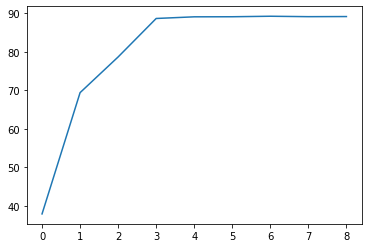

In [8]:
plt.plot(loss_values)